In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import gurobipy as gp
from gurobipy import GRB
import scipy

In [2]:
rng = np.random.default_rng(344)

In [3]:
def simulationBD(params, n, tmax, ts, plot=False, plotShow=True, initial_state=0):
    '''
    Simulate a sample path of the birth death model
    Sample n values at intervals of ts after a burn-in time of tmax

    params: dict of reaction rate constants
    n: number of samples
    tmax: burn in time
    ts: time between samples
    '''

    # initialise time and state
    t = 0
    path = [initial_state]
    jump_times = [0]

    # simulate for burn-in time and time between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x = path[-1]

        # transition rates
        q_tx = params['k_tx']
        q_deg = x * params['k_deg']
        q_hold = q_tx + q_deg

        # holding time in current state
        t_hold = -np.log(rng.uniform()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        outcome = [1, 2]
        prob = [
            q_tx / q_hold,
            q_deg / q_hold
        ]
        jump = rng.choice(outcome, p=prob)
        match jump:
            case 1:
                path.append(x + 1)
            case 2:
                path.append(x - 1)

    # create step function of sample path from jump times and jump values
    path_function = scipy.interpolate.interp1d(jump_times, path, kind='previous')

    # take values at sampling times as samples from stationary dist
    sample_times = [tmax + i * ts for i in range(n)]
    samples = path_function(sample_times)
    samples = [int(x) for x in samples]

    # plot sample path
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, path_function(x), label="Sample path")
        #plt.axvline(tmax, label="Burn-in time", color="orange")
        plt.xlabel("Time")
        plt.ylabel("Count")
        plt.legend()
        if plotShow: plt.show()

    return samples

In [4]:
def simulationBDInt(params, n, tmax, ts, plot=False, plotShow=True, initial_state=(0, 0)):
    '''
    Simulate a sample path of the birth death interaction model
    Sample n values at intervals of ts after a burn-in time of tmax

    params: dict of reaction rate constants
    n: number of samples
    tmax: burn in time
    ts: time between samples
    '''

    # initialise time and state
    t = 0
    path = [initial_state]
    jump_times = [0]

    # simulate for burn-in time and time between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x1, x2 = path[-1][0], path[-1][1]

        # transition rates
        q_tx_1 = params['k_tx_1']
        q_tx_2 = params['k_tx_2']
        q_deg_1 = x1 * params['k_deg_1']
        q_deg_2 = x2 * params['k_deg_2']
        q_reg = x1 * x2 * params['k_reg']
        q_hold = q_tx_1 + q_tx_2 + q_deg_1 + q_deg_2 + q_reg

        # holding time in current state
        t_hold = -np.log(rng.uniform()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        outcome = [1, 2, 3, 4, 5]
        prob = [
            q_tx_1 / q_hold,
            q_tx_2 / q_hold,
            q_deg_1 / q_hold,
            q_deg_2 / q_hold,
            q_reg / q_hold
        ]
        jump = rng.choice(outcome, p=prob)
        match jump:
            case 1:
                path.append((x1 + 1, x2))
            case 2:
                path.append((x1, x2 + 1))
            case 3:
                path.append((x1 - 1, x2))
            case 4:
                path.append((x1, x2 - 1))
            case 5:
                path.append((x1 - 1, x2 - 1))

    # take the transcript states
    x1_path = [state[0] for state in path]
    x2_path = [state[1] for state in path]

    # create step function of sample path from jump times and jump values
    x1_path_function = scipy.interpolate.interp1d(jump_times, x1_path, kind='previous')
    x2_path_function = scipy.interpolate.interp1d(jump_times, x2_path, kind='previous')

    # take values at sampling times as samples from stationary dist
    sample_times = [tmax + i * ts for i in range(n)]
    x1_samples = x1_path_function(sample_times)
    x2_samples = x2_path_function(sample_times)
    samples = [(int(x1_samples[i]), int(x2_samples[i])) for i in range(n)]

    # plot sample paths
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, x1_path_function(x), label="X1 sample path")
        plt.plot(x, x2_path_function(x), label="X2 sample path")
        #plt.axvline(tmax, label="Burn-in time", color="orange")
        plt.xlabel("Time")
        plt.ylabel("Count")
        plt.legend()
        if plotShow: plt.show()

    return samples

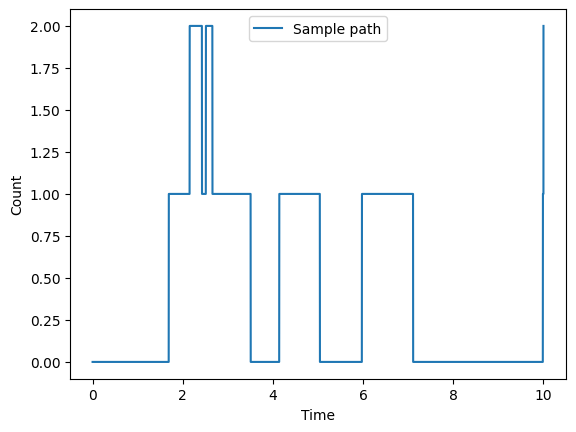

In [6]:
params_BD = {
    'k_tx': 1,
    'k_deg': 1
}

sample_BD = simulationBD(params_BD, n=1, tmax=10, ts=10, plot=True)

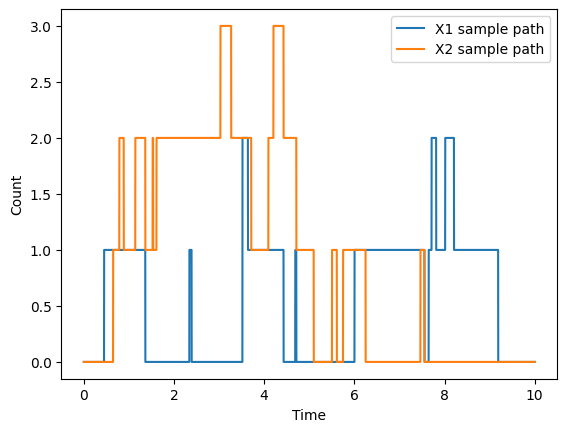

In [7]:
params_BDInt = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}

sample_BDInt = simulationBDInt(params_BDInt, n=1, tmax=10, ts=10, plot=True)

# Simulation of realistic parameters

Developing and testing inference methods in 'birth-death-interaction', 'telegraph-interaction' and 'cross-model-interaction' we have so far manuallly chosen parameter values used to simulate data: setting all to 1, or varying transcription rates or gene on / off rates.

However, to understand how the methods will perform on real data (and how performance could be improved) we now focus on simulating realistic parameters which can then be used to simulate realistic data, emulating the data observed by real experiments.

## Poisson model of mRNA

We begin by considering a poisson model of mRNA counts (birth-death) and estimate the parameter ranges when fitting to observed data.

From https://www.nature.com/articles/nature10098 the half-lives of mRNA are observed $ \in (10^{0}, 10^{1.5})$ which are related to their degradation rate $k_{deg}$ by: $t_{1/2} = \frac{ln(2)}{k_{deg}}$, resulting in *approximately* $log(k_{deg}) \in (-1.5, 0)$.

The mean of observed mRNA counts is $ \in (10^{-2}, 10^{2}) $ and following the model, the mean of observed counts is $ \frac{k_{tx} \mathbb{E}[\beta]}{k_{deg}}$, so combining with the range of degradation rates results in *approximately* $log(k_{tx} \mathbb{E}[\beta]) \in (-3, 2) $.

We assume that the log-rates are uniformly distributed over these ranges (although the half lives may follow a more normal-like distribution).

## Capture efficiency

Using data to estimate capture efficiency (VASA-seq data) by normalising total transcript counts per cell to have a mean of 0.06 and fitting a Beta distribution results in the *approximate* values of $\beta = 20$ and $\alpha=1$ (which can be changed to vary the mean capture efficiency of $\frac{\alpha}{\alpha + \beta}$ which is 0.05 for the values provided (almost 0.06))

## Simulation process

### Individual genes

- Sample $ log(k_{tx} \mathbb{E}[\beta]) \sim \text{Unif}(-3, 2) $ and $ log(k_{deg}) \sim \text{Unif}(-1.5, 0) $
- Exponentiate and scale by mean capture efficiency $ \mathbb{E} = 0.06 $ to get $k_{tx}$ and $k_{deg}$ values
- Sample capture efficiency $\beta_{j}$ for each cell $j$ from beta distribution
- Simulate data using reaction rates, downscale using capture efficiency

### Interacting pair of genes

- Sample transcription and degradation rates for each gene as before
- Sample capture efficiency for each cell as before
- Choose a value of $k_{reg}$

However, note that the 'strength' of interaction depends on the magnitude of $k_{reg}$ *relative* to the other parameters: it will be much easier to detect interaction in data simulated using $k_{reg} = 0.1$ if the other rates are of magnitude $0.01$ (as then equivalent to a value of 10 relative to other rates of 1) compared to if the other rates are of magnitude $10$ (as then equivalent to a value of 0.01 relative to other rates of 1)

# Simulation: individual genes

Text(0, 0.0, 'Beta = 20')

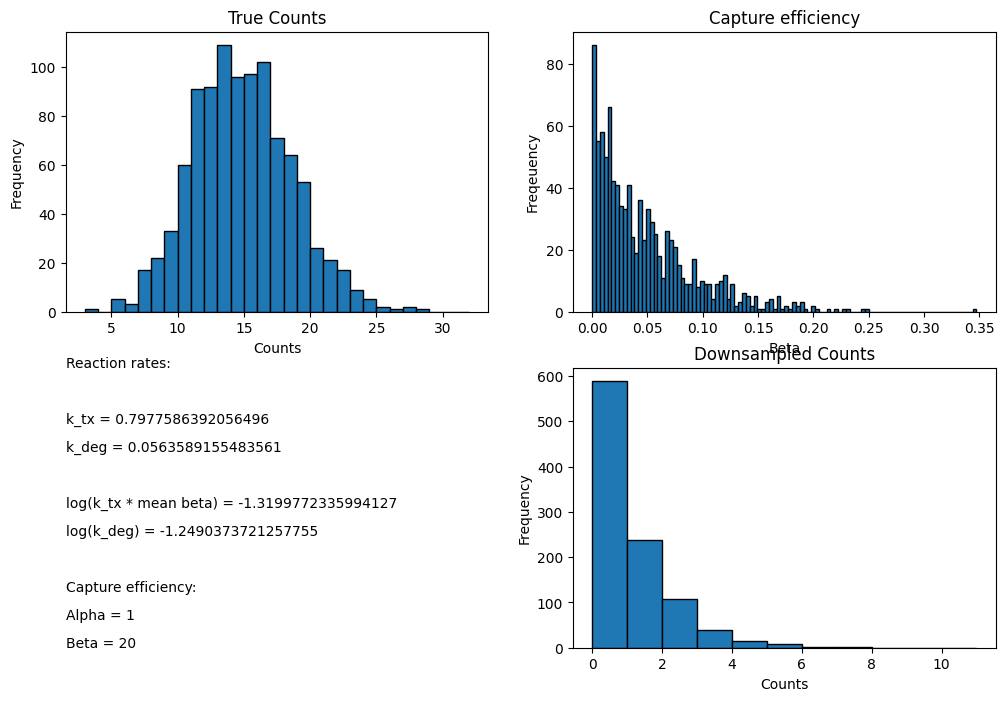

In [150]:
# sample size (cells)
n = 1000

# sample rates from log-uniform distribution
log_k_tx_beta = rng.uniform(-3, 2)
log_k_deg = rng.uniform(-1.5, 0)

# exponentiate and scale
k_tx = (10 ** log_k_tx_beta) / 0.06
k_deg = 10 ** log_k_deg

# sample counts from stationary distribution
sample = rng.poisson(lam=k_tx / k_deg, size=n)

# plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].hist(sample, bins=range(int(np.min(sample)), int(np.max(sample)) + 5), edgecolor='black');
axs[0, 0].set_xlabel("Counts")
axs[0, 0].set_ylabel("Frequency")
axs[0, 0].set_title("True Counts")

# sample capture efficiency from beta distribution
beta = rng.beta(a=1, b=20, size=n)

# plot
axs[0, 1].hist(beta, bins=100, edgecolor='black');
axs[0, 1].set_xlabel("Beta")
axs[0, 1].set_ylabel("Freqeuency")
axs[0, 1].set_title("Capture efficiency")

# downsample counts using capture efficiency
sample_downsampled = rng.binomial(sample, beta)

# plot
axs[1, 1].hist(sample_downsampled, bins=range(int(np.min(sample_downsampled)), int(np.max(sample_downsampled)) + 5), edgecolor='black');
axs[1, 1].set_xlabel("Counts")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].set_title("Downsampled Counts")

# display info
axs[1, 0].axis('off')
axs[1, 0].text(0, 1.0, f"Reaction rates:")
axs[1, 0].text(0, 0.8, f"k_tx = {k_tx}")
axs[1, 0].text(0, 0.7, f"k_deg = {k_deg}")
axs[1, 0].text(0, 0.5, f"log(k_tx * mean beta) = {log_k_tx_beta}")
axs[1, 0].text(0, 0.4, f"log(k_deg) = {log_k_deg}")
axs[1, 0].text(0, 0.2, f"Capture efficiency:")
axs[1, 0].text(0, 0.1, f"Alpha = 1")
axs[1, 0].text(0, 0.0, f"Beta = 20")

# Simulation: interacting pair of genes

k_tx_1 = 9.564702884961067
k_tx_2 = 1.365128916000253
k_deg_1 = 0.7968096263246749
k_deg_2 = 0.2610588522661454
k_reg = 0.2610588522661454


Text(0, 0.0, 'Beta = 20')

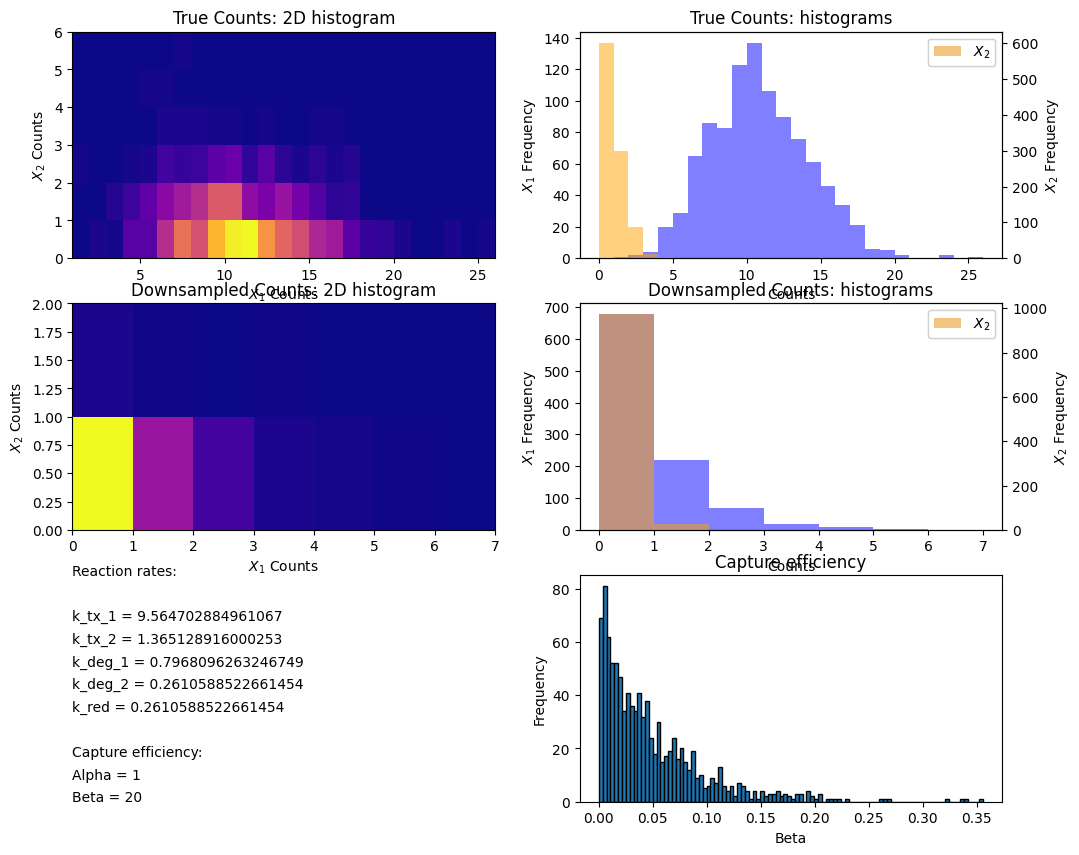

In [80]:
# sample size (cells)
n = 1000

# simulation parameters
params = {}

# sample rates from log-uniform distribution for both genes
log_k_tx_beta_1 = rng.uniform(-3, 2)
log_k_tx_beta_2 = rng.uniform(-3, 2)
log_k_deg_1 = rng.uniform(-1.5, 0)
log_k_deg_2 = rng.uniform(-1.5, 0)

# exponentiate and scale
params['k_tx_1'] = (10 ** log_k_tx_beta_1) / 0.06
params['k_tx_2'] = (10 ** log_k_tx_beta_2) / 0.06
params['k_deg_1'] = 10 ** log_k_deg_1
params['k_deg_2'] = 10 ** log_k_deg_2

# select interaction strength: relative to degradation rate
params['k_reg'] = 1 * params['k_deg_2']

for key, val in params.items():
    print(f"{key} = {val}")

# sample counts from stationary distribution
sample = simulationBDInt(params, n=n, tmax=100, ts=10) 

x1_sample = [x[0] for x in sample]
x2_sample = [x[1] for x in sample]

# plot

# 2D histogram of true counts
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs[0, 0].hist2d(x1_sample, x2_sample, bins=[range(int(np.min(x1_sample)), int(np.max(x1_sample)) + 2), range(int(np.min(x2_sample)), int(np.max(x2_sample)) + 2)],
                 cmap='plasma')
axs[0, 0].set_xlabel(r"$X_{1}$ Counts")
axs[0, 0].set_ylabel(r"$X_{2}$ Counts")
axs[0, 0].set_title("True Counts: 2D histogram")

# separate histograms of observed counts
axs[0, 1].hist(x1_sample, bins=range(int(np.min(x1_sample)), int(np.max(x1_sample)) + 2), alpha=0.5, color="blue", label=r"$X_{1}$");
axs01_twin = axs[0, 1].twinx()
axs01_twin.hist(x2_sample, bins=range(int(np.min(x2_sample)), int(np.max(x2_sample)) + 2), alpha=0.5, color="orange", label=r"$X_{2}$");
axs[0, 1].set_xlabel("Counts")
axs[0, 1].set_ylabel(r"$X_{1}$ Frequency")
axs01_twin.set_ylabel(r"$X_{2}$ Frequency")
axs[0, 1].set_title("True Counts: histograms")
axs[0, 1].legend()
axs01_twin.legend()

# sample capture efficiency from beta distribution
beta = rng.beta(a=1, b=20, size=n)

# downsample counts using capture efficiency
x1_sample_downsampled = rng.binomial(x1_sample, beta).tolist()
x2_sample_downsampled = rng.binomial(x2_sample, beta).tolist()
sample_downsampled = list(zip(x1_sample_downsampled, x2_sample_downsampled))

# 2D histogram of downsampled counts
axs[1, 0].hist2d(x1_sample_downsampled, x2_sample_downsampled, bins=[range(int(np.min(x1_sample_downsampled)), int(np.max(x1_sample_downsampled)) + 2), range(int(np.min(x2_sample_downsampled)), int(np.max(x2_sample_downsampled)) + 2)],
                 cmap='plasma')
axs[1, 0].set_xlabel(r"$X_{1}$ Counts")
axs[1, 0].set_ylabel(r"$X_{2}$ Counts")
axs[1, 0].set_title("Downsampled Counts: 2D histogram")

# separate histograms of downsampled counts
axs[1, 1].hist(x1_sample_downsampled, bins=range(int(np.min(x1_sample_downsampled)), int(np.max(x1_sample_downsampled)) + 2), alpha=0.5, color="blue", label=r"$X_{1}$");
axs11_twin = axs[1, 1].twinx()
axs11_twin.hist(x2_sample_downsampled, bins=range(int(np.min(x2_sample_downsampled)), int(np.max(x2_sample_downsampled)) + 2), alpha=0.5, color="orange", label=r"$X_{2}$");
axs[1, 1].set_xlabel("Counts")
axs[1, 1].set_ylabel(r"$X_{1}$ Frequency")
axs11_twin.set_ylabel(r"$X_{2}$ Frequency")
axs[1, 1].set_title("Downsampled Counts: histograms")
axs[1, 1].legend()
axs11_twin.legend()

# capture efficiency
axs[2, 1].hist(beta, bins=100, edgecolor='black');
axs[2, 1].set_xlabel("Beta")
axs[2, 1].set_ylabel("Frequency")
axs[2, 1].set_title("Capture efficiency")

# display info
axs[2, 0].axis('off')
axs[2, 0].text(0, 1.0, f"Reaction rates:")
axs[2, 0].text(0, 0.8, f"k_tx_1 = {params['k_tx_1']}")
axs[2, 0].text(0, 0.7, f"k_tx_2 = {params['k_tx_2']}")
axs[2, 0].text(0, 0.6, f"k_deg_1 = {params['k_deg_1']}")
axs[2, 0].text(0, 0.5, f"k_deg_2 = {params['k_deg_2']}")
axs[2, 0].text(0, 0.4, f"k_red = {params['k_reg']}")
axs[2, 0].text(0, 0.2, f"Capture efficiency:")
axs[2, 0].text(0, 0.1, f"Alpha = 1")
axs[2, 0].text(0, 0.0, f"Beta = 20")

# Optimization: detecting interaction

# Appendix

## Invariance under parameter scaling

The stationary distribution of the Stochastic Reaction Networks being simulated is invariant under scaling of all reaction rate parameters by a constant multiple, as it does not affect the transition probabilities (and so the jump chain) and scales holding times equally for all states, so the proportion of time spent in each state remains the same (and so the stationary distribution).

For this reason, the exact values of the reaction rate parameters are not identifiable given only information about the stationary distribution, but only their values relative to each other. So we fix one parameter (usually a degradation rate to 1) when performing inference. To compare the true parameter values to the results we should scale the true values to match this (e.g. divide all by the true value of the degradation rate that was fixed to 1 during inference)

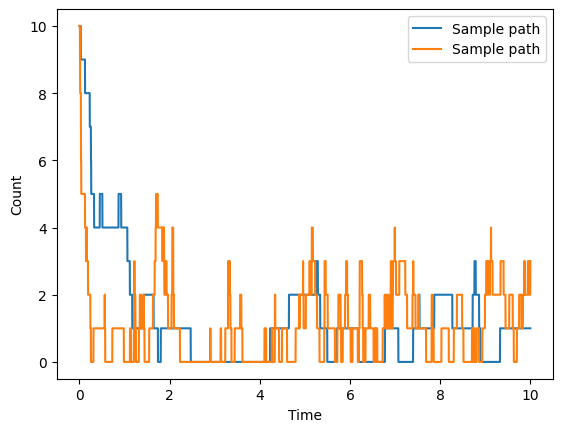

In [151]:
# parameter sets: scaled by a multiple
params_BD_1 = {
    'k_tx': 1,
    'k_deg': 1
}

params_BD_2 = {
    'k_tx': 10,
    'k_deg': 10
}

# plot sample paths
sample_BD_1 = simulationBD(params_BD_1, n=1, tmax=10, ts=10, plot=True, plotShow=False, initial_state=10)
sample_BD_2 = simulationBD(params_BD_2, n=1, tmax=10, ts=10, plot=True, initial_state=10)

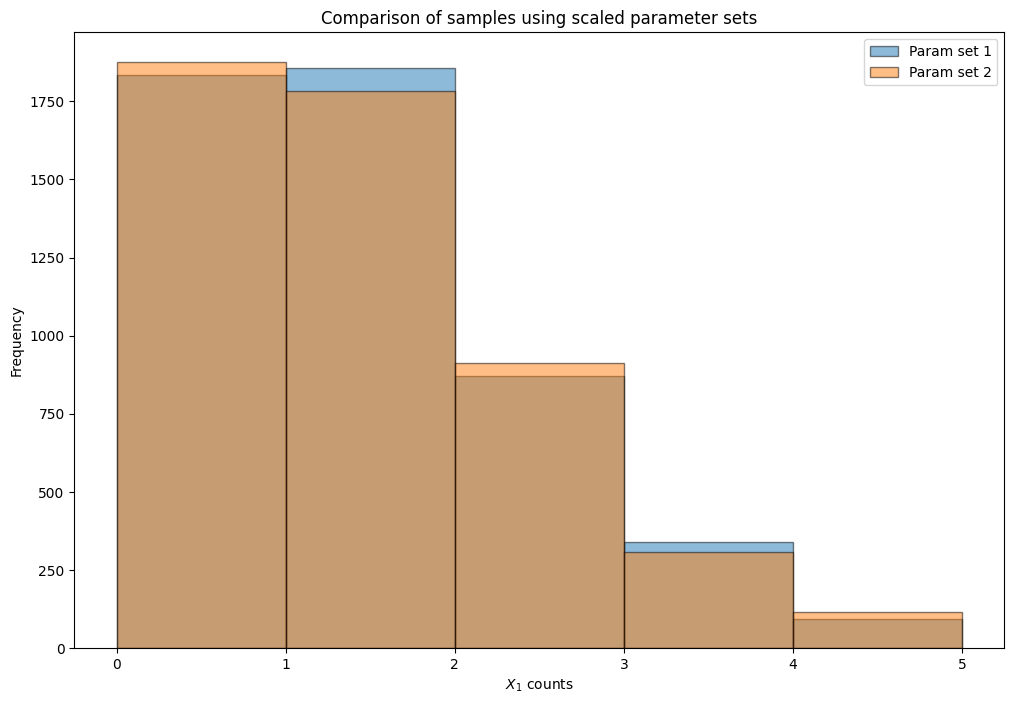

In [152]:
# take large samples using both parameter sets
sample_BD_1 = simulationBD(params_BD_1, n=5000, tmax=100, ts=10)
sample_BD_2 = simulationBD(params_BD_2, n=5000, tmax=100, ts=10)

# plot sample histograms
fig = plt.figure(figsize=(12, 8))
plt.hist(sample_BD_1, bins=range(6), alpha=0.5, edgecolor='black', label="Param set 1");
plt.hist(sample_BD_2, bins=range(6), alpha=0.5, edgecolor='black', label="Param set 2");
plt.xlabel(r"$X_{1}$ counts")
plt.ylabel("Frequency")
plt.title("Comparison of samples using scaled parameter sets")
plt.legend()
plt.show()

As shown by the sample paths, multplying all rates by 10 means the orange sample path has much shorter holding times in each state, jumping around much more than the blue path.

However, as shown by the histograms, the distribution of samples (assumed from the stationary distribution) is the same for both parameter sets.

This shows that our samples, and results based on them, will be invariant under scaling all parameters.